# CSE 144, Winter 2024 - Final Project

Team members:
1. Sneha De
2. Karthi Sankar

This notebook is organized into the following sections:
1. Setup: installation and importing libaries, defining constants.
2. Data loading: downloading from Kaggle, loading and processing the training, validation, and test sets
3. Defining the model: augmentation layers, model to implement transfer learning, plus additional layers
4. Evaluation: predicting and classifying the test data
5. Exporting: parsing the `submission.csv` file and the model's weights.

In [ ]:
# GCP Vertex AI Workbench only has TF 2.11 Kernels, need to upgrade Keras to 3
!pip install -q tensorflow==2.11.0
!pip install -q --upgrade keras
!pip install -q kaggle numpy

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.11.0 requires keras<2.12,>=2.11.0, but you have keras 3.1.1 which is incompatible.


In [ ]:
# Imports and constants
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import matplotlib.pyplot as plt
import zipfile    # Extracting zip files
import csv        # I/O with CSV files

import tensorflow as tf
print("Tensorflow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
tf.get_logger().setLevel('ERROR') # https://stackoverflow.com/a/55142079

import keras
print("Keras version:", keras.__version__)

SEED = 42
AUG_SEED = 84
NUM_CLASSES = 100
VALIDATION_SPLIT = 0.2
EPOCHS = 10
IMAGE_SIZE = 300
BATCH_SIZE = 32

Tensorflow version: 2.11.0
Num GPUs Available:  1
Keras version: 3.1.1


## Loading data

<!-- Download the datasets from the [Kaggle competition download page](https://www.kaggle.com/competitions/ucsc-cse-144-Winter-2024-final-project/data), and ensure it is uploaded to the Files in Colab or in the same directory as this file in a `.zip` format. -->

The following code:
1. Downloads the dataset from Kaggle using ones own `kaggle.json` file.
2. Unzips the folder and loads data according to their inferred categories (i.e, their parent folder name).
3. Split into training, validation, and testing sets with any preprocessing required.

In [ ]:
raw_data_name = "ucsc-cse-144-Winter-2024-final-project"
raw_data_path = raw_data_name + ".zip"

# Must have a valid kaggle.json with an API key
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c ucsc-cse-144-Winter-2024-final-project -q

In [ ]:
# Unzipping folder: https://stackoverflow.com/a/56947239
try:
    with zipfile.ZipFile(raw_data_path, "r") as zip_ref:
        zip_ref.extractall(raw_data_name)
    print("Extraction successful.")
except zipfile.BadZipFile:
    print("BadZipFile: The specified file is not a valid ZIP file.")
except FileNotFoundError:
    print(f"FileNotFoundError: The file '{raw_data_path}' does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")

Extraction successful.


In [ ]:
train_dir = raw_data_name + "/train/train"
test_dir = raw_data_name + "/test/test"
CLASS_NAMES = [str(num) for num in range(100)]

# Documentation on loading data with Keras: https://keras.io/api/data_loading/
train_ds_org, val_ds_org = keras.utils.image_dataset_from_directory(
    directory=train_dir,
    labels="inferred",
    label_mode= "int",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_split=VALIDATION_SPLIT,
    seed=SEED,
    subset="both",      # Return both training and validation
    class_names=CLASS_NAMES,
)

# Test data is being mis-sorted due to alphanumeric sorting. Must load in manually
def load_data(image_path):
    img = tf.image.decode_image(tf.io.read_file(image_path), channels=3)
    img.set_shape([None, None, 3]) # manually tell its RGB
    img = tf.image.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    return img
test_file_names = tf.data.Dataset.from_tensor_slices([test_dir + "/" + str(n) + ".jpg" for n in range(1000)])
test_ds_org = test_file_names.map(lambda x: load_data(x)).batch(BATCH_SIZE)


# Preprocess according to model needs: https://keras.io/api/layers/preprocessing_layers/image_preprocessing/rescaling/
using_resnet = False
if using_resnet:
    preprocessing = keras.applications.resnet_v2.preprocess_input
else:
    preprocessing = keras.applications.efficientnet_v2.preprocess_input

# Used in the plotting
def undo_scaling(img):
    # Add offset, multiply back
    img = (img + 1) * 127.5
    return img

train_ds = train_ds_org.map(lambda x, y: (preprocessing(x), y))
val_ds = val_ds_org.map(lambda x, y: (preprocessing(x), y))
test_ds = test_ds_org.map(lambda x: preprocessing(x))

print(f"Number of batches in training: {len(train_ds)}, test: {len(test_ds)}")

Found 1000 files belonging to 100 classes.
Using 800 files for training.
Using 200 files for validation.
Number of batches in training: 25, test: 32


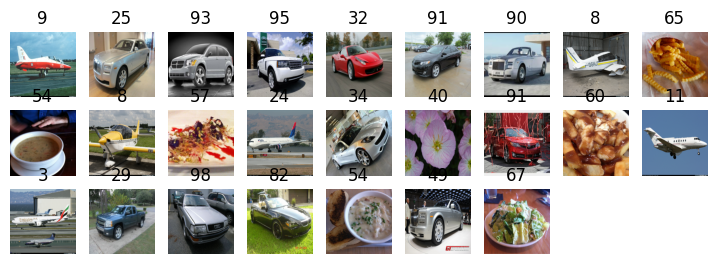

In [ ]:
# https://www.tensorflow.org/tutorials/load_data/images#visualize_the_data
def plot_images(dataset, is_test=False, has_labels=False, num_images=16):
    import math
    size = 12
    grid = max(9, int(math.sqrt(num_images)))

    plt.figure(figsize=(9, 9))

    if not is_test:
        for images, labels in dataset.take(1):
            for i in range(num_images):
                if using_resnet: # Undo preprocessing
                    img = undo_scaling(images[i].numpy())
                else:
                    img = images[i].numpy()

                ax = plt.subplot(grid, grid, i + 1)
                plt.imshow(img.astype("uint8"), cmap=plt.cm.binary)
                if has_labels:
                    plt.title(CLASS_NAMES[labels[i]])
                plt.axis("off")
    else:
        for images in dataset.take(1):
            for i in range(num_images):
                if using_resnet: # Undo preprocessing
                    img = undo_scaling(images[i].numpy())
                else:
                    img = images[i].numpy()

                ax = plt.subplot(grid, grid, i + 1)
                plt.imshow(img.astype("uint8"), cmap=plt.cm.binary)
                plt.axis("off")

plot_images(train_ds, num_images=25, has_labels=True)

## Data augmentation

Since we only have 10 images per class, we must create more variations of the data to work with. The augmentations will be done dynamically during the training process so more random variations of the data is processed by the model.

In [ ]:
from keras import layers

augmentations = keras.Sequential([
    layers.RandomRotation((-0.15, 0.15), seed=AUG_SEED),
    layers.RandomContrast(0.35, seed=AUG_SEED),
    layers.RandomBrightness(0.05, seed=AUG_SEED),
    layers.RandomFlip("horizontal", seed=AUG_SEED),
], name="augmentations")

## Define Model

Keras supports [transfer learning](https://keras.io/guides/transfer_learning/) by loading in pre-trained model weights and tuning to custom data.

In [ ]:
from keras import layers

# In a function to recreate an instance of it each time the next cell is ran
def create_model():
    # Input shape: spatial dimensions * 3 channels (RGB)
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)

    base_model = keras.applications.EfficientNetV2B3(
        weights="imagenet",       # Load weights pre-trained on ImageNet.
        input_shape=input_shape,
        include_top=False,        # Do not include the last layer
        pooling="avg",
    )
    for layer in base_model.layers:
        layer.trainable = False
    base_model.trainable = False  # Freezing the base model

    num_layers = len(base_model.layers)

    # How many layers to unfreeze at the end of the model
    num_end_unfreeze = 10
    for i in range(num_end_unfreeze):
        base_model.layers[num_layers - 1 - i].trainable = True

    # Assumes preprocessing has already been applied
    inputs = keras.Input(shape=input_shape)
    x = augmentations(inputs)
    x = base_model(x, training = False)
    X = layers.Flatten()(x)

    x = layers.Dense(100, activation="relu", kernel_regularizer='l2')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3, seed = SEED)(x)

    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)
    model = keras.Model(inputs, outputs, name="our_model")

    return model

# Train Model

The model is trained with an Adam optimizer, and with a learning rate initialized to 1e-3 but which decays at a rate of 0.9 per 100 steps.

In [ ]:
STEPS_PER_EPOCH = BATCH_SIZE * 10

# https://keras.io/api/optimizers/
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 1e-3,
    decay_steps = 100,
    decay_rate = 0.9,
    staircase = False,
)

optimizer = keras.optimizers.Adam(
    learning_rate = lr_schedule,
    use_ema = True,
)

# https://keras.io/api/callbacks/early_stopping/
early_stopper = keras.callbacks.EarlyStopping(monitor="val_loss", patience=2)

# Get new instance of model
model = create_model()
model.summary()

# Compile the model
model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# Prefetch for performance: https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# Fit the model: repeat the dataset while there are still steps left
train_history = model.fit(train_ds.repeat(),
                          validation_data=(val_ds),
                          epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          callbacks=[early_stopper],
                          shuffle=True,
                )

Model: "our_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentations (Sequential)      │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b3 (Functional)  │ (None, 1536)           │    12,930,622 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       153,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        10,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,094,822 (49.95 MB)

 Trainable params: 928,960 (3.54 MB)

 Non-trainable params: 12,165,862 (46.41 MB)

Epoch 1/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 89s 220ms/step - accuracy: 0.3925 - loss: 4.2878 - val_accuracy: 0.5250 - val_loss: 2.8332
Epoch 2/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 203ms/step - accuracy: 0.9219 - loss: 1.1135 - val_accuracy: 0.5450 - val_loss: 2.0394
Epoch 3/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 202ms/step - accuracy: 0.9806 - loss: 0.5282 - val_accuracy: 0.5450 - val_loss: 1.8985
Epoch 4/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 202ms/step - accuracy: 0.9887 - loss: 0.3347 - val_accuracy: 0.5650 - val_loss: 1.8033
Epoch 5/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 202ms/step - accuracy: 0.9930 - loss: 0.2346 - val_accuracy: 0.5700 - val_loss: 1.6879
Epoch 6/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 202ms/step - accuracy: 0.9942 - loss: 0.1823 - val_accuracy: 0.5650 - val_loss: 1.6437
Epoch 7/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 202ms/step - accuracy: 0.9937 - loss: 0.1576 - val_accuracy: 0.6100 - val_loss: 1.5891
Epoch 8/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 202ms/step - accuracy: 0.9941 - loss: 0

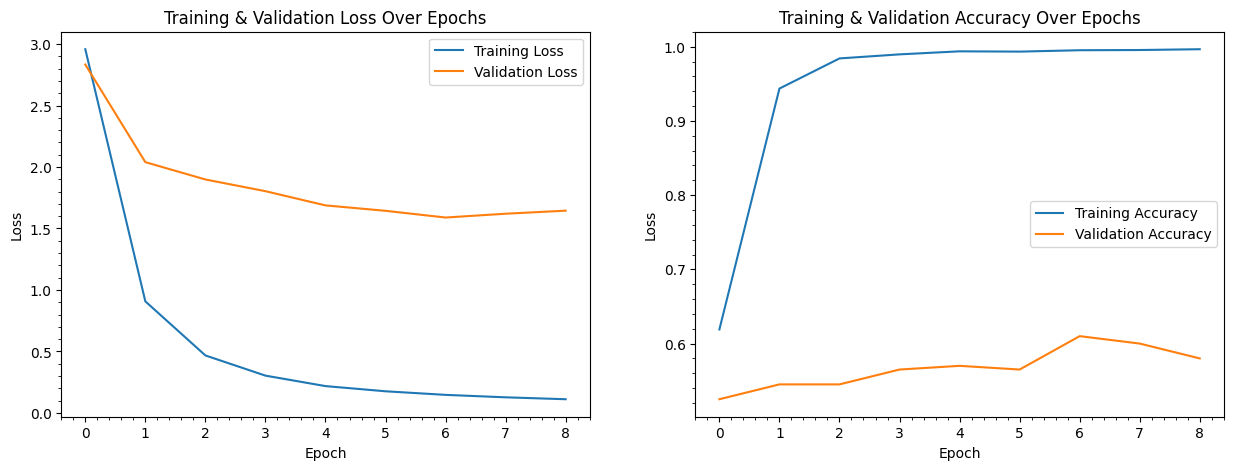

In [ ]:
def plot_training_history(history):
    num_epochs =  len(history.history["loss"])
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.set_title("Training & Validation Loss Over Epochs")
    ax1.plot(np.arange(num_epochs), history.history["loss"], label='Training Loss')
    ax1.plot(np.arange(num_epochs), history.history["val_loss"], label='Validation Loss')
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.minorticks_on()
    ax1.legend()

    ax2.set_title("Training & Validation Accuracy Over Epochs")
    ax2.plot(np.arange(num_epochs), history.history["accuracy"], label="Training Accuracy")
    ax2.plot(np.arange(num_epochs), history.history["val_accuracy"], label="Validation Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.minorticks_on()
    ax2.legend()

plot_training_history(train_history)

# Make Predictions

The model predicts the categories of each test instance by giving a probability of being in each of the classes. This is then converted into the most probable classificaiton for each image

The classifications are then exported into a `submission.csv` in the Files tab of Colab (or in the same directory if running locally).

In [ ]:
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
predictions = model.predict(test_ds)
print("Finished making predictions.")

32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 275ms/step
Finished making predictions.


In [ ]:
# For every instance (axis=1), return its most most likely classification
# pred[i][j] = probability that instance i is of class j
# class[i] = maximumum from (pred[i]) for labelling instance i
# https://saif-shabou.netlify.app/post/clothing-image-classification/
classifications = np.argmax(predictions, axis=1)
print("Finished classifying.")

Finished classifying.


In [ ]:
def export_submission(classes):
  filename = "submission.csv"
  header = ["ID", "Label"]
  with open(filename, "w") as subcsv:
    writer = csv.writer(subcsv)
    writer.writerow(header)

    for img_id, label in enumerate(classifications):
        img_path = str(img_id) + ".jpg"
        writer.writerow([img_path, label])
  print(f"Exported to {filename} successfully")

export_submission(classifications)

Exported to submission.csv successfully


In [ ]:
# Save weights into a file
# https://keras.io/api/models/model_saving_apis/weights_saving_and_loading/
weights_filename = "./cse144-final-project-weights.weights.h5"
model.save_weights(weights_filename)
print(f"Exported model weights to {weights_filename} successfully")

Exported model weights to ./cse144-final-project-weights.weights.h5 successfully
